<a href="https://colab.research.google.com/github/ShubhamKNIT/learn-python/blob/main/notebooks/04_transfer_learning_with_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TF

Transfer learning can be used to work on exisiting models on same kind of problems.

- Can leverage the architecture used in the model for our own problem.
- Exisiting model with freezed weights can be directly used on the data.

In [ ]:
!nvidia-smi

Sun Aug 18 11:34:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get the data ready

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-08-18 11:34:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  17.8MB/s    in 11s     

2024-08-18 11:34:25 (15.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
zip_ref = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 10 director

## Creating data loaders (preparing the data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

We'll be using three callbacks

- `tensorboard` track the model experiments.
- `ModelCheckpoint` for model checkpoint (Callback to save the Keras model or model weights at some frequency)
- `EarlyStopping` to prevent model from overfitting

In [ ]:
import datetime

def create_tb_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving tensorboard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using TFHub



In [ ]:
import tensorflow as tf

## Creating and testing ResNet TFHub Feature Extraction Model

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(include_top=False,
                                                weights='imagenet',
                                                input_shape=IMAGE_SHAPE + (3,))

resnet_model.trainable = False

model_1 = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history_r1 = model_1.fit(train_data,
                         epochs = 5,
                         validation_data = test_data,
                         callbacks = [create_tb_callback('tb_callback', 'exp_r1')])

Saving tensorboard log files to: tb_callback/exp_r1/20240818-093635
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 896ms/step - accuracy: 0.2312 - loss: 2.2878 - val_accuracy: 0.6212 - val_loss: 1.2243
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 527ms/step - accuracy: 0.7098 - loss: 1.0113 - val_accuracy: 0.7152 - val_loss: 0.8940
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.8091 - loss: 0.6732 - val_accuracy: 0.7372 - val_loss: 0.8075
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 559ms/step - accuracy: 0.8575 - loss: 0.5440 - val_accuracy: 0.7436 - val_loss: 0.7679
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 427ms/step - accuracy: 0.8875 - loss: 0.4466 - val_accuracy: 0.7568 - val_loss: 0.7355


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_history(history):
    history = pd.DataFrame(history.history)
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    ax[0].plot(history['loss'], label = 'loss', c = 'blue')
    ax[0].plot(history['val_loss'], label = 'val-loss', c = 'orange')
    ax[0].set_title('model-loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(history['accuracy'], label = 'accuracy', c = 'blue')
    ax[1].plot(history['val_accuracy'], label = 'val-accuracy', c = 'orange')
    ax[1].set_title('model-accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()

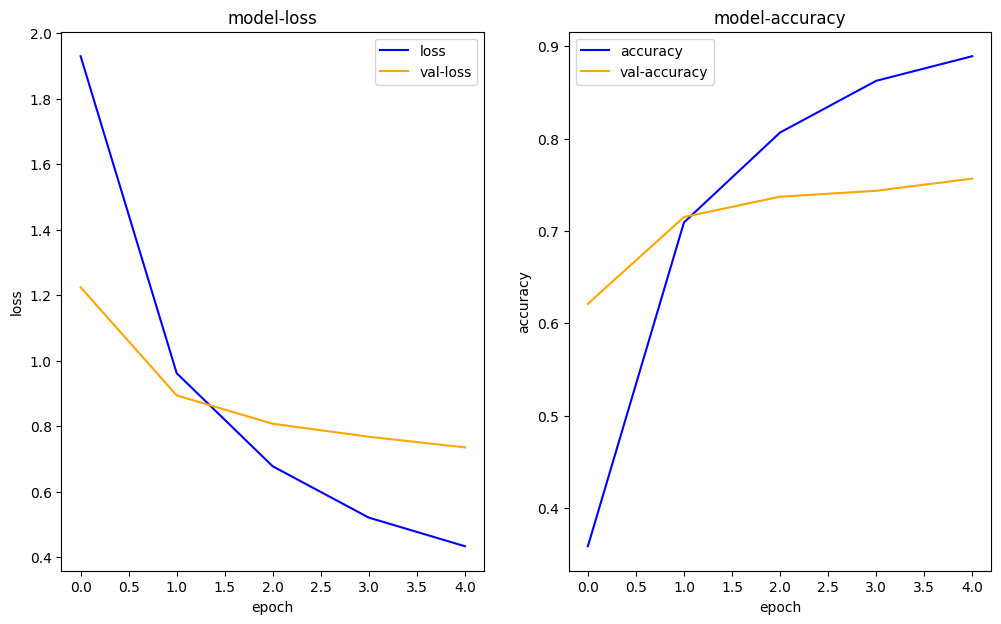

In [ ]:
plot_history(history_r1)

In [ ]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

## Creating and testing EfficientNet TFHub Feature Extraction Model

In [ ]:
efficentnet_model = tf.keras.applications.EfficientNetB3(include_top=False)

efficentnet_model.trainable = False

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SHAPE + (3,)),
    efficentnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
history_e1 = model_2.fit(train_data,
                         epochs = 5,
                         validation_data = test_data,
                         callbacks = [create_tb_callback('tb_callback', 'exp_e1')])

Saving tensorboard log files to: tb_callback/exp_e1/20240818-100253
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.0934 - loss: 2.3391 - val_accuracy: 0.1000 - val_loss: 2.3362
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.1007 - loss: 2.3450 - val_accuracy: 0.1000 - val_loss: 2.3228
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.1166 - loss: 2.3427 - val_accuracy: 0.1000 - val_loss: 2.3312
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.0787 - loss: 2.3348 - val_accuracy: 0.1000 - val_loss: 2.3255
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - accuracy: 0.0893 - loss: 2.3324 - val_accuracy: 0.1000 - val_loss: 2.3297


In [ ]:
model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          15,370 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,829,647 (41.31 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

 Optimizer params: 30,742 (120.09 KB)

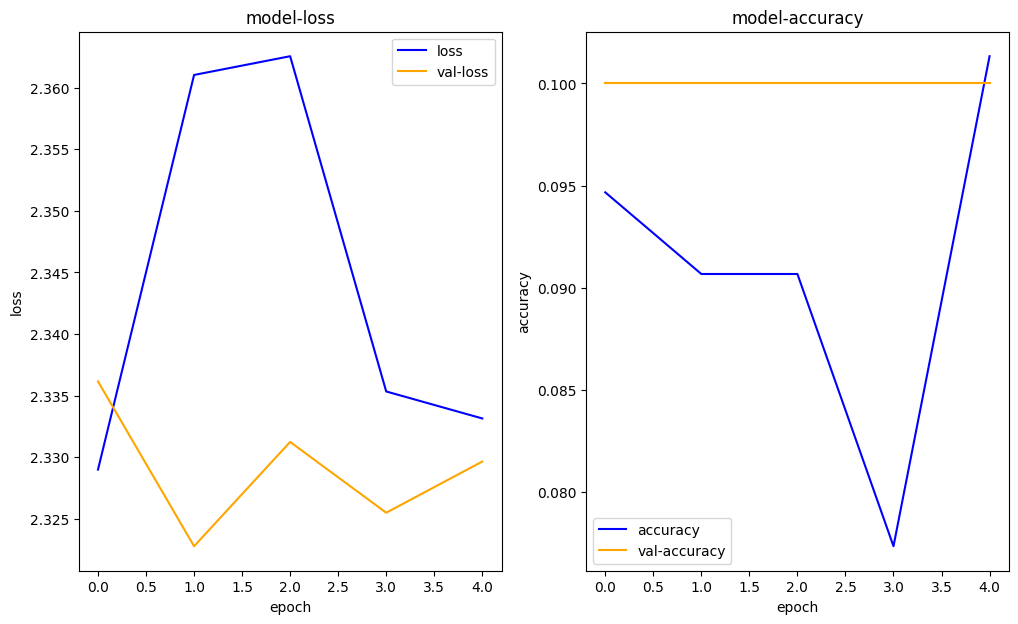

In [ ]:
plot_history(history_e1)

## Creating own Dataset Class

Ref: [Load and Preprocess data](https://www.tensorflow.org/tutorials/load_data/images)

What we can do with this class:
- We can get class_labels
- We can get train_ds and test_ds
- We can plot the prepared dataset


In [ ]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

class prepare_dataset:
    """
    Class to prepare the dataset for training and testing

    Args:
        train_dir: path to the directory containing the training dataset
        test_dir: path to the directory containing the testing dataset

    Functions:
        get_class_names: returns the list of class names
        get_label: returns the label of the image
        decode_img: decodes the image
        process_path: returns the image and label
        configure_for_performance: configures the dataset for performance
        get_dataset: returns the train_ds and test_ds
        plot_image_from_ds: plots the images from the dataset

    Returns:
        train_ds: training dataset
        test_ds: testing dataset
    """

    def __init__(self, train_dir, test_dir):
        """
        Args:
            train_dir: path to the directory containing the training dataset
            test_dir: path to the directory containing the testing dataset
        """
        self.train_dir = pathlib.Path(train_dir)
        self.test_dir = pathlib.Path(test_dir)
        self.class_names = self.get_class_names()  # Initialize class names

    def get_class_names(self):
        """
        Returns:
            class_names: list of class names
        """
        return np.array(sorted([item.name for item in self.train_dir.glob('*') if item.name != "LICENSE.txt"]))

    def get_label(self, file_path):
        """
        Returns the label of the image
        Args:
            file_path: path to the image
        Returns:
            label: label of the image
        """
        parts = tf.strings.split(file_path, os.path.sep)
        one_hot = parts[-2] == self.class_names
        return tf.cast(one_hot, tf.int32)

    def decode_img(self, img):
        """
        Decodes the image
        Args:
            img: image to be decoded
        Returns:
            img: decoded image
        """
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        return img

    def process_path(self, file_path):
        """
        Returns the image and label
        Args:
            file_path: path to the image
        Returns:
            img: image
            label: label of the image
        """
        label = self.get_label(file_path)
        img = tf.io.read_file(file_path)
        img = self.decode_img(img)
        return img, label

    def configure_for_performance(self, ds):
        """
        Configures the dataset for performance
        Args:
            ds: dataset to be configured
        Returns:
            ds: configured dataset
        """
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(32)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def get_dataset(self):
        """
        Returns:
            train_ds: training dataset
            test_ds: testing dataset
        """
        train_ds = tf.data.Dataset.list_files(str(self.train_dir/'*/*'), shuffle=False)
        test_ds = tf.data.Dataset.list_files(str(self.test_dir/'*/*'), shuffle=False)

        train_ds = train_ds.map(self.process_path, num_parallel_calls=AUTOTUNE)
        test_ds = test_ds.map(self.process_path, num_parallel_calls=AUTOTUNE)

        train_ds = self.configure_for_performance(train_ds)
        test_ds = self.configure_for_performance(test_ds)

        return train_ds, test_ds

    def plot_image_from_ds(self, ds):
        """
        Plots the images from the dataset
        Args:
            ds: dataset to plot
        Returns:
            None
        """
        image_batch, label_batch = next(iter(ds))

        plt.figure(figsize=(10, 10))
        for i in range(min(9, len(image_batch))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            label = np.argmax(label_batch[i].numpy())
            plt.title(self.class_names[label])
            plt.axis("off")
        plt.show()


In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'
ds = prepare_dataset(train_dir, test_dir)

In [ ]:
train_ds, test_ds = ds.get_dataset()

In [ ]:
class_names = ds.get_class_names()

In [ ]:
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

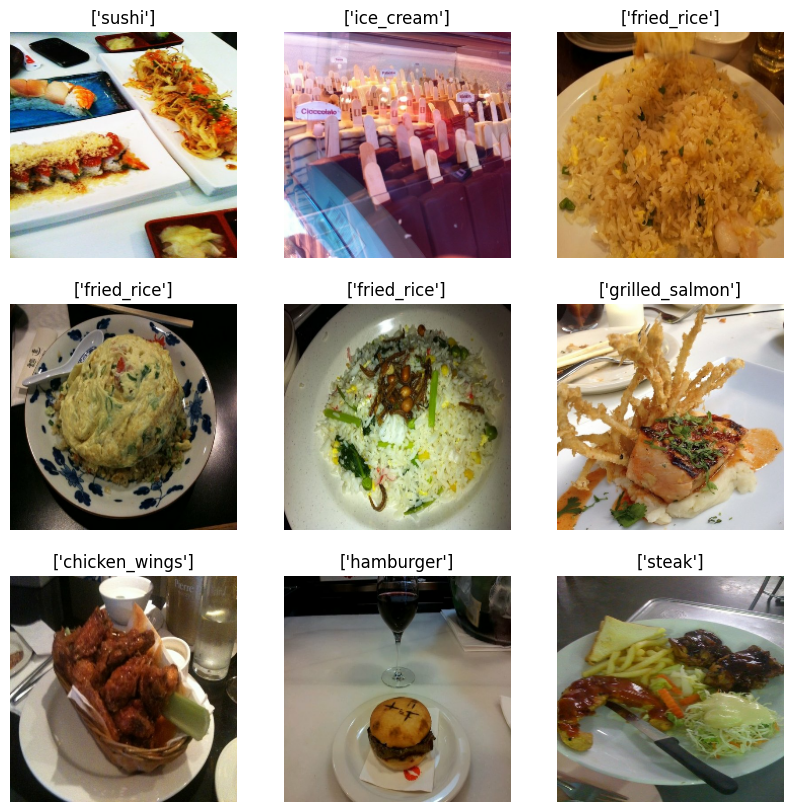

In [ ]:
ds.plot_image_from_ds(train_ds)

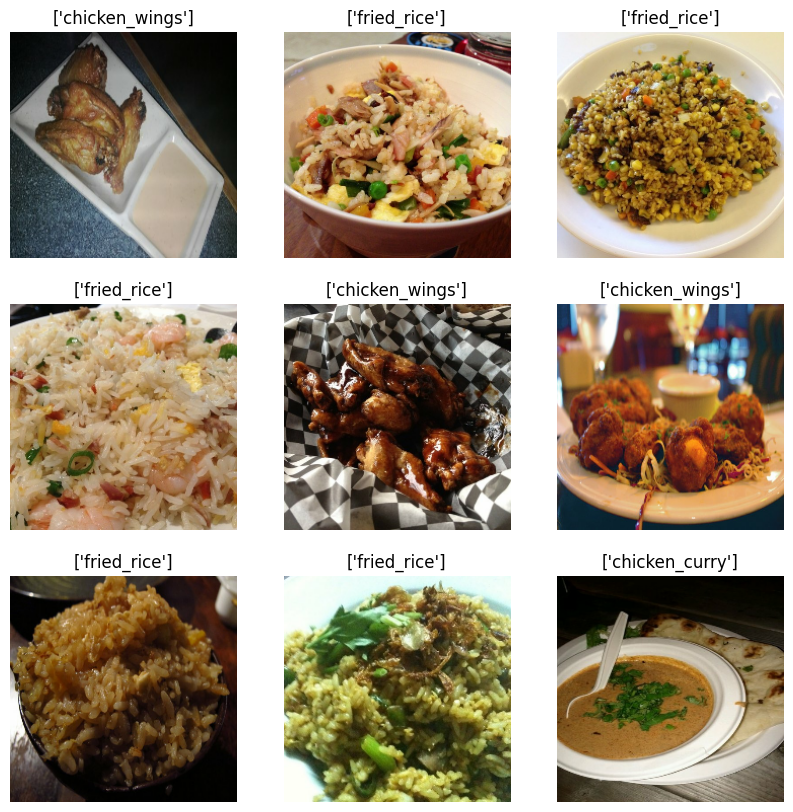

In [ ]:
ds.plot_image_from_ds(test_ds)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 10)


> `Note`: [EfficientNet Paper](https://arxiv.org/pdf/1905.11946)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None))>

## Model 0: Building a transfer learning model using Keras Functional API

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

x = base_model(inputs, training = False)
print(f"Shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
print(f"Shape after output layer: {outputs.shape}")

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

model_0.summary()

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Shape after output layer: (None, 10)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history_0 = model_0.fit(train_ds,
                         epochs = 5,
                         validation_data = test_ds,
                         callbacks = [create_tb_callback('tb_callback', 'exp_0')])

Saving tensorboard log files to: tb_callback/exp_0/20240818-125920
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2748 - loss: 2.0886 - val_accuracy: 0.6780 - val_loss: 1.3636
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.7052 - loss: 1.2791 - val_accuracy: 0.7808 - val_loss: 0.9568
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.8151 - loss: 0.8921 - val_accuracy: 0.8056 - val_loss: 0.7889
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.8333 - loss: 0.7530 - val_accuracy: 0.8120 - val_loss: 0.6996
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8407 - loss: 0.6264 - val_accuracy: 0.8224 - val_loss: 0.6457
